# Microarrays & Metabolism

Studying metabolism from the trancriptome is challenging. So this protocol has helped in the intial steps in a research topic focused in metabolism, this information in conjuction with the metabolome can be very informative. It does the intial steps in the microarray analysis ando also the connection from different data bases. 
The data we are going to usea also have the difficulty that it comes from Rat instead of human. 

## Protocol
### Installation

All of the analysis is performed in R. As such the first thing you will need is to install R. For installation instructions see http://r-project.org. In Ubuntu R can be installed via the Terminal using

```sh
sudo apt-get install r-base r-base-dev
```

Additionally some of the dependencies of dycone require development versions of some libraries for web security and scraping. In Ubuntu and Debian those can be installed via

```sh
sudo apt-get install libxml2-dev libcurl4-openssl-dev libssl-dev libgmp-dev
```

In [ ]:
install.packages(c("devtools","ff","doMC"))
source("http://bioconductor.org/biocLite.R")
biocLite(c("Biobase", "IRanges", "AnnotationDbi", "affy", "frma", "genefilter",
    "GEOquery", "hgu133plus2.db", "hgu133plus2frmavecs", "limma","pdInfoBuilder","GEOquery"))

We are going to use a costume CDF from brain array. 

In [ ]:
library(pdInfoBuilder)
library(ff)
 library(doMC)
 registerDoMC(10)

download.file("http://mbni.org/customcdf/20.0.0/entrezg.download/ragene20st_Rn_ENTREZG_20.0.0.zip","tmp.zip")
unzip("tmp.zip")
 dir()
z <- cdf2table("ragene20st_Rn_ENTREZG.cdf")
seed <- new("GenericPDInfoPkgSeed", table=z, author = "me", email = "me@mine.org", species = "Rattus_norvegicus", pkgName = "pd.ragene20st")
makePdInfoPackage(seed)
install.packages("pd.ragene20st/", repos = NULL)

### Getting the data
For this example we are going to use  GSE65374. In this data they used GSK932121A, an inhibitor of complex III of the electron transport chain.

In [ ]:
library(GEOquery)
getGEOSuppFiles("GSE65374")

In [ ]:
untar("GSE65374/GSE65374_RAW.tar", exdir="data")
cels <- list.files("data/", pattern = "[gz]")
sapply(paste("data", cels, sep="/"), gunzip)
cels

To describe the data we run the following code in the shell.

```sh
ls *.CEL | perl -pe 's/(GSM15940\d\d_Liver_[1-9]_RaGene-2_0-st_.CEL)/$1\t$1\tctrl/'|perl -pe 's/(GSM15940\d\d_Liver_1[0-2]_RaGene-2_0-st_.CEL)/$1\t$1\tctrl/'|perl -pe 's/(GSM15940\d\d_Liver_1[3-8]_RaGene-2_0-st_.CEL)/$1\t$1\tGSK932121/'|perl -pe 's/(GSM15940\d\d_Liver_2\d_RaGene-2_0-st_.CEL)/$1\t$1\tGSK932121/'|perl -pe's/GSM1594069/Name\tFileName\tTarget\nGSM1594069/' >phenodata.txt 
```

### Reading the data

In [1]:
library(oligo,quietly=T, warn.conflicts=F)
sample_info<-read.table("data/phenodata.txt",header=T)
condition <- sample_info$Target
condition <- factor(condition)
raw_data <-read.celfiles(paste("data",sample_info$FileName,sep="/"),pkgname ='pd.ragene20st')
pData(raw_data)$cell_line <- sample_info$Target
pData(raw_data)$condition <- condition



Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit

Welcome to oligoClasses version 1.34.0
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Reading in : data/GSM1594069_Liver_1_RaGene-2_0-st_.CEL
Reading in : data/GSM1594070_Liver_2_RaGene-2_0-st_.CEL
Reading in : data/GSM1594071_Liver_3_RaGene-2_0-st_.CEL
Reading in : data/GSM1594072_Liver_4_RaGene-2_0-st_.CEL
Reading in : data/GSM1594073_Liver_5_RaGene-2_0-st_.CEL
Reading in : data/GSM1594074_Liver_6_RaGene-2_0-st_.CEL
Reading in : data/GSM1594075_Liver_7_RaGene-2_0-st_.CEL
Reading in : data/GSM1594076_Liver_8_RaGene-2_0-st_.CEL
Reading in : data/GSM1594077_Liver_9_RaGene-2_0-st_.CEL
Reading in : data/GSM1594078_Liver_10_RaGene-2_0-st_.CEL
Reading in : data/GSM1594079_Liver_11_RaGene-2_0-st_.CEL
Reading in : data/GSM1594080_Liver_12_RaGene-2_0-st_.CEL
Reading in : data/GSM1594081_Liver_13_RaGene-2_0-st_.CEL
Reading in : data/GSM1594082_Liver_14_RaGene-2_0-st_.CEL
Reading in : data/GSM1594083_Liver_16_RaGene-2_0-st_.CEL
Reading in : data/GSM1594084_Liver_17_RaGene-2_0-st_.CEL
Reading in : data/GSM1594085_Liver_18_RaGene-2_0-st_.CEL
Reading in : data/GSM1594086_Liver_20_Ra

This is the line to normalize

In [2]:
eset <- rma(raw_data)

Background correcting... OK
Normalizing... OK


Calculating Expression


### QC
We start with boxplots and histogram of the raw data and the normalized data.

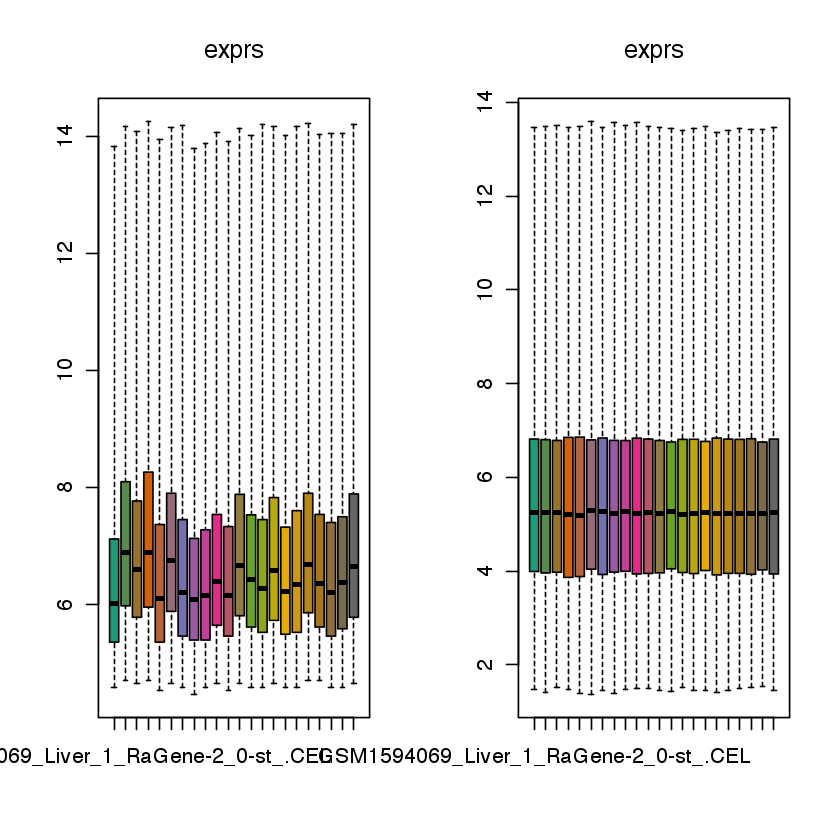

In [3]:
par(mfrow=c(1,2))
boxplot(raw_data)
boxplot(eset)



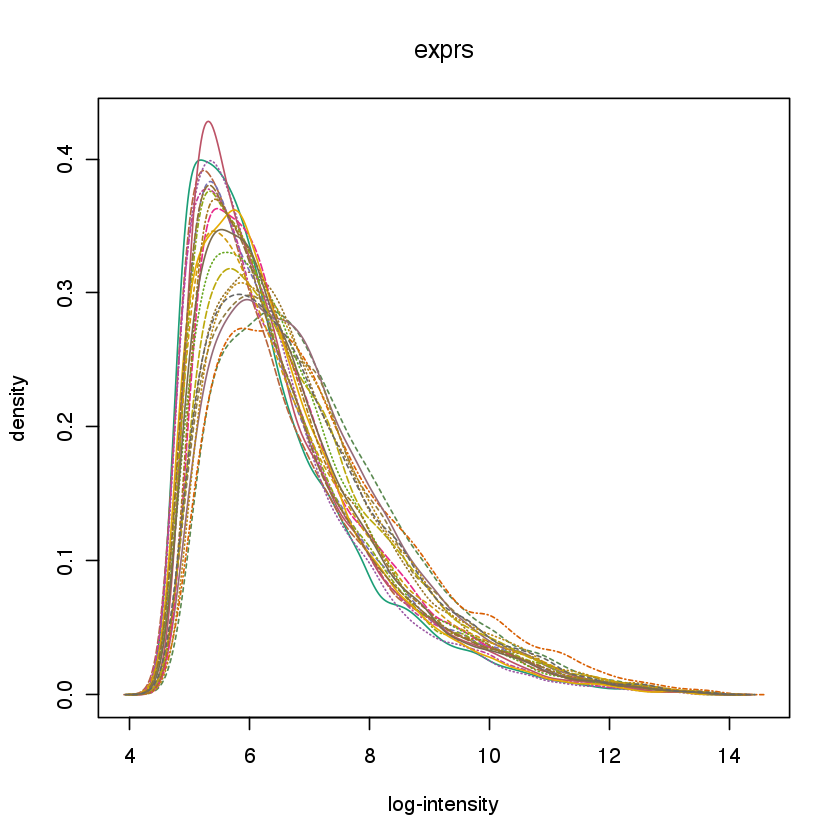

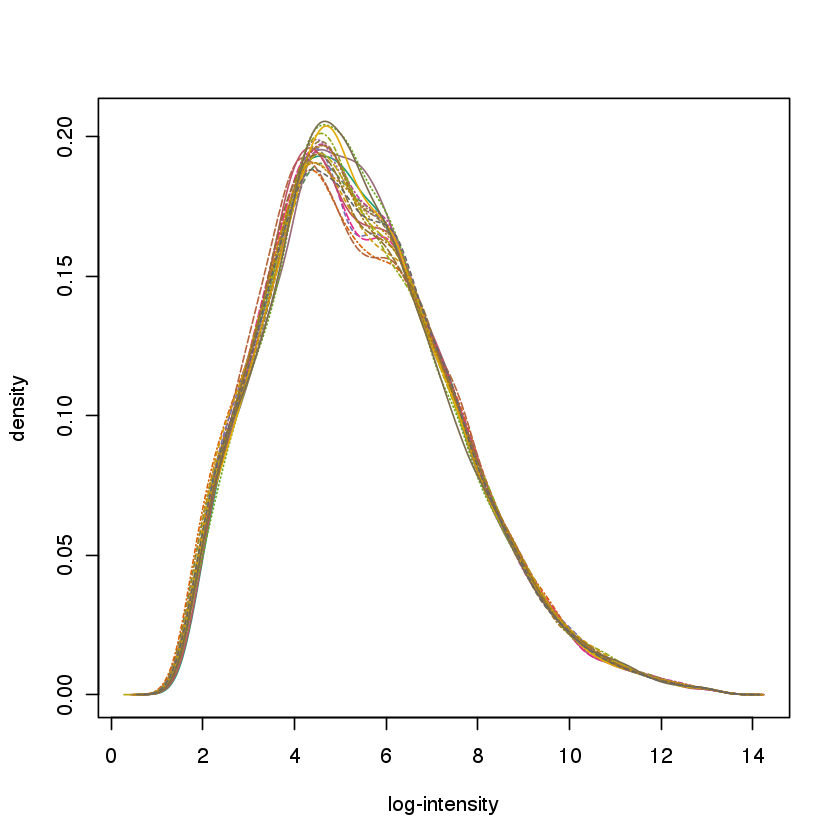

In [4]:
hist(raw_data)
hist(eset)

There are no mayor deaviation in the data, and the normalization is bringing the intensities from all of the chips into distributions of similar characteristics. 
Next we check the NUSE, and RLE. 
RLE the closer is to 0 the better, while NUSE the closer it is to 1 the better. which most od the chips are.

In [5]:
fit1 <- fitProbeLevelModel(raw_data,target = "mps1")


Background correcting... OK
Normalizing... OK
Summarizing... OK
Extracting...
  Estimates... OK
  StdErrors... OK
  Weights..... OK
  Residuals... OK
  Scale....... OK


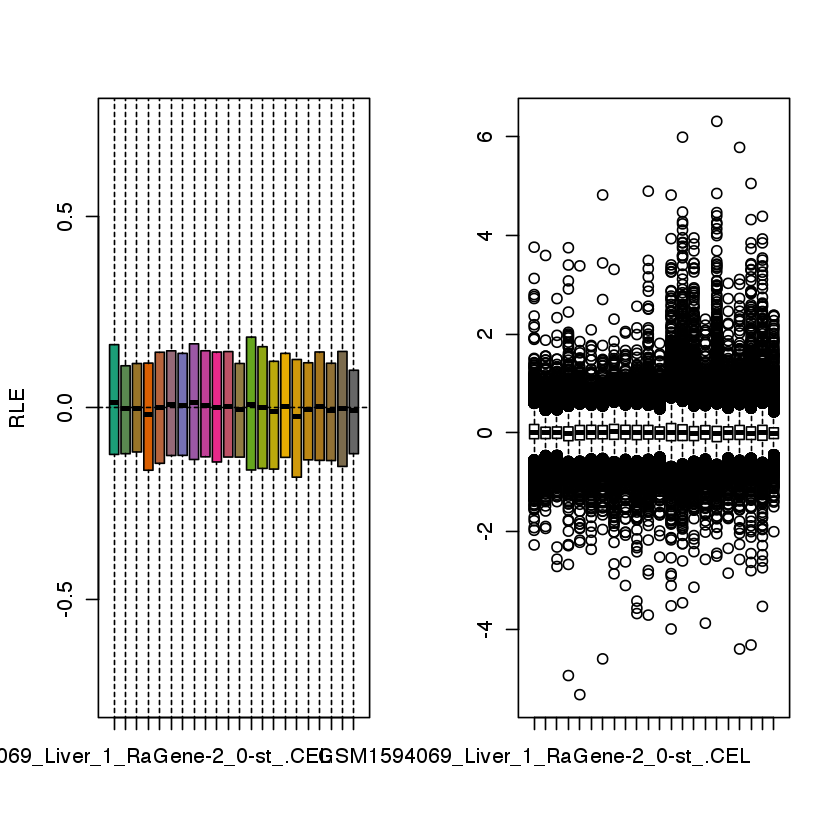

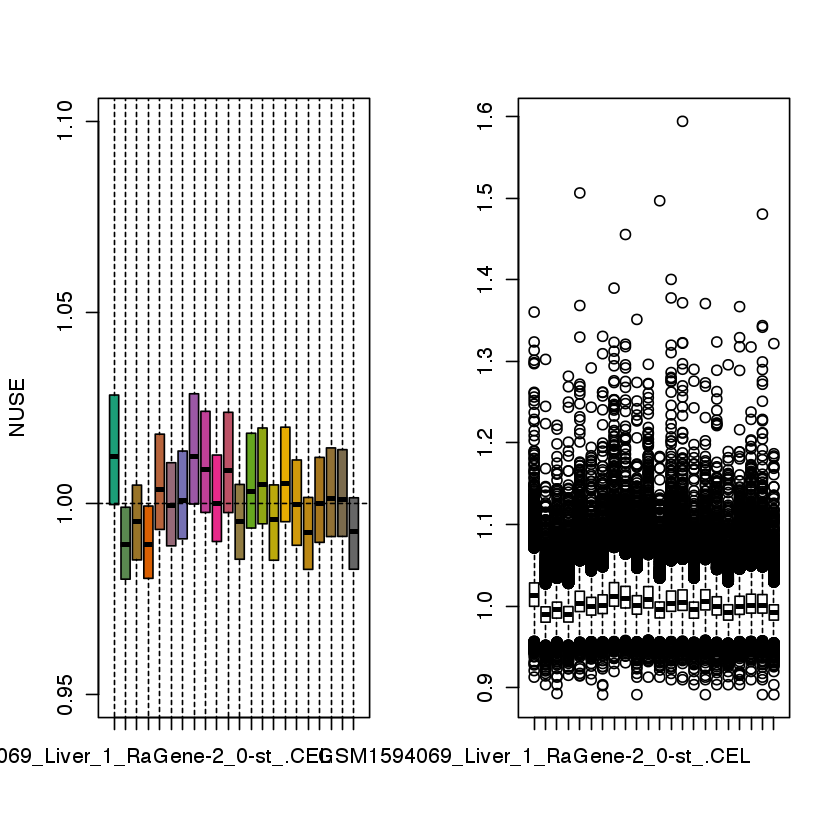

In [6]:
par(mfrow=c(1,2))
boxplot(RLE(fit1))
boxplot(NUSE(fit1))


We can also check if the microarrays by itself can diferentiate between conditions.

In [7]:
library(ggplot2)
pca <- prcomp(t(exprs(eset)))
sum(pca$sdev[1:2])/sum(pca$sdev)

[1] 0.1859574

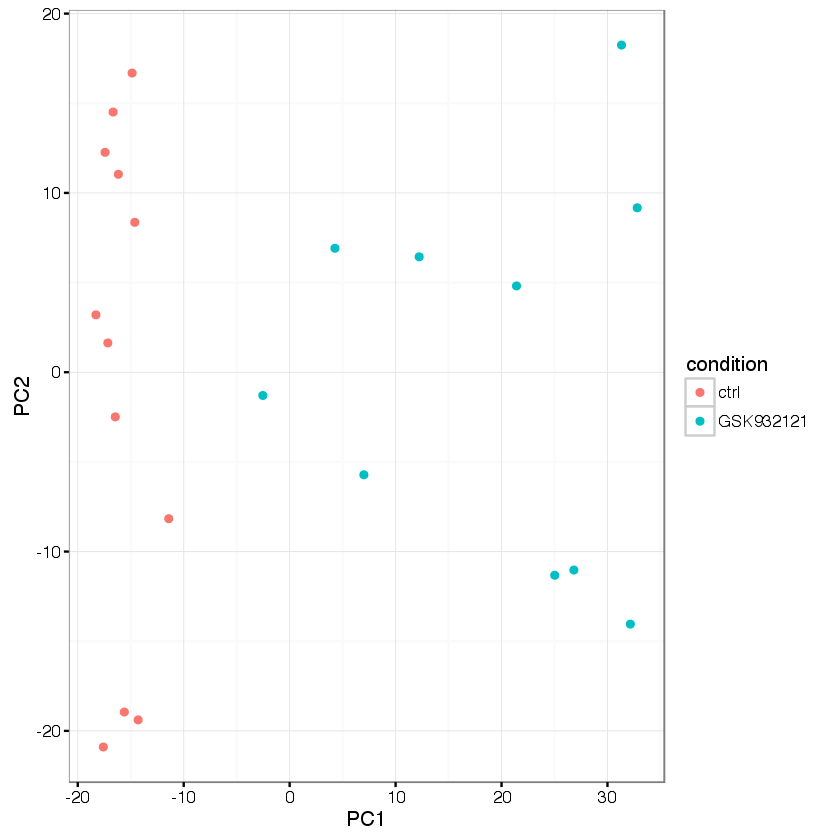

In [8]:
ggplot(data.frame(pca$x), aes(x=PC1, y=PC2,z=PC3)) + theme_bw() + 
  geom_point(aes(col=condition))

In [9]:
cl <- kmeans(t(exprs(eset)), 2)
normal_cluster <- cl$cluster[1] # first condition is normal
cl_err <- sum(cl$cluster[condition == "normal"] != normal_cluster)/length(cl$cluster)
cat(sprintf("Clustering error between normal/disease: %f%%\n", cl_err*100))

Clustering error between normal/disease: 0.000000%


### Analysis
#### GMT
One of the most useful enrichment analysis is GSEA (http://software.broadinstitute.org/gsea/doc/GSEAUserGuideFrame.html?_Interpreting_GSEA_Results). 
It has the advatange that you can provide the database that suits your question the most. 
In this case we are goint to use the Small metabolite pathway  database. Their data is easy to download here http://smpdb.ca/downloads. 
Another problem we are going to deal is that this database uses ids from human, and we need rat.

In [10]:
id<-cbind(ID=gsub("_at","",rownames(exprs(eset))),DESCRIPTION=rownames(exprs(eset)))
write.table(cbind(id,exprs(eset)),"ragene20st_ENTREZG_rma.txt",row.names=F,sep="\t",quote=F)

library(AnnotationDbi)
library(org.Hs.eg.db)
library(org.Rn.eg.db)

genes<- read.csv(paste("proteins.csv",sep="/"))
SMPDB<-read.csv(paste("metabolites.csv",sep="/"))
SMPDB<-SMPDB[SMPDB$Pathway.Subject=="Metabolic",c("Pathway.Name" ,"Pathway.Subject",  "KEGG.ID"  )]


genes<-genes[genes$Pathway.Subject%in%SMPDB$Pathway.Subject,]
ko <- (merge(read.table("http://rest.kegg.jp/link/ko/rno"), read.table("http://rest.kegg.jp/link/ko/hsa")
                   ,by.x=2,by.y=2))
colnames(ko)<-c("ko","rno","hsa")
ko$rno<-gsub("rno:","",ko$rno)
con_up<-read.table("http://rest.kegg.jp/conv/hsa/uniprot")
colnames(con_up)<-c("up","hsa")
con_up$up<-gsub("up:","",con_up$up)
ensG<-merge(ko,con_up,by='hsa')
paths<-paste( unique(genes$Pathway.Name),unique(genes$SMPDB.ID),sep="\t")
mergin<-function(x){
  (paste(unique(ensG[ensG$up%in%genes[genes$SMPDB.ID==x,"Uniprot.ID"],"rno"]),collapse = "\t"))
}
gmt<-sapply(unique(genes$SMPDB.ID),mergin)
gmt<-cbind(paths,data.frame(gmt))
head(gmt)

write.table(gmt,paste("SMPDB.KEGG.ko.gmt",sep="/"),col.names = F,row.names = F,quote = F,sep="\t")

paths,gmt
Alanine Metabolism SMP00055,292023 301254 24792 307759 81670 25104
Aspartate Metabolism SMP00067,289276 684425 315150 116483 304919 81632 24379 24380 298483 287305 100360621 59085 25612 79251 25698 293128 291556 24240 246307 685325
Glutamate Metabolism SMP00072,361641 497840 81632 24379 24380 297417 360518 24398 192268 25283 29739 24399 24957 25721 307759 81670 116686 25458 117544 353255 297393 100911132 290868 498486 24240 291133 641316 295088
Glutathione Metabolism SMP00015,295037 171341 499688 499689 57298 114846 309465 81869 24421 64352 494499 24426 25260 494500 29487 24424 24422 300850 363205 108348148 103690044 24423 501110 289197 108348061 408206 156275 116684 25283 29739 24404 29326 259233 294744 298376 64317 113919 81641 116686 25458 362368 64026
Citric Acid Cycle SMP00057,170587 81654 298942 299201 24368 94173 103690168 25179 100125384 114096 81829 360975 290566 50655 79250 25104 117098 29554 289950 157074 298596 289217 363061 361071 362404 114597
Alpha Linolenic Acid and Linoleic Acid Metabolism SMP00018,691905 691810 24653 296091 691907 691813 311341 84575 171400 315851 83512


You shoul now have everything needed to run GSEA

#### Diferential Expression
In order to use limma we are going to make sure the data is normal like

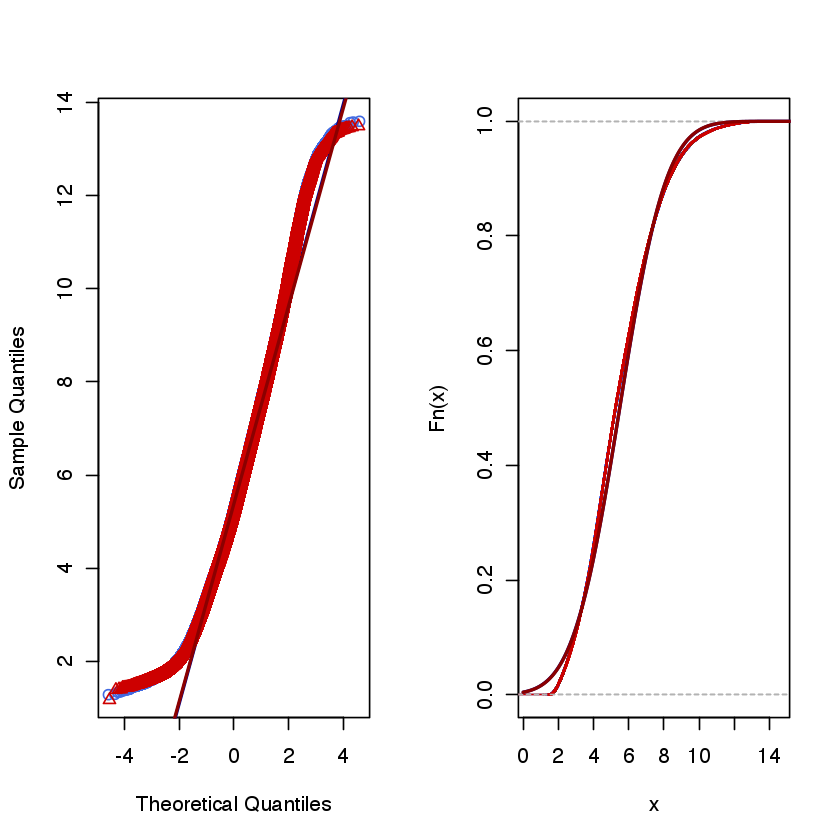

In [11]:
par(mfrow = 1:2)
qqnorm(exprs(eset[,condition=="ctrl"]), pch = 1, col = "royalblue", main = "")
qqline(exprs(eset[,condition=="ctrl"]), lwd = 2, col = "darkblue")
points(qqnorm(exprs(eset[,condition=="GSK932121"]), plot.it = F), pch = 2, col = "red3")
qqline(exprs(eset[,condition=="GSK932121"]), lwd = 2, col = "darkred")

x <- seq(0, 16, length.out = 256)
plot(ecdf(exprs(eset[,condition=="ctrl"])), pch = 1, col = "royalblue", main = "")
lines(x, pnorm(x, mean(exprs(eset[,condition=="ctrl"]), na.rm = T)
               , sd(exprs(eset[,condition=="ctrl"]), na.rm = T)), lwd = 2,col = "darkblue")
plot(ecdf(exprs(eset[,condition=="GSK932121"])), pch = 2, add = T, col = "red3")
lines(x, pnorm(x, mean(exprs(eset[,condition=="GSK932121"]), na.rm = T), sd(exprs(eset[,condition=="GSK932121"])
                                                                      , na.rm = T)), lwd = 2,col = "darkred")



In [12]:
library(limma)
design <- model.matrix(~ 0 + condition)
colnames(design) <- levels(condition)
fit <- lmFit(eset, design)
contrast.matrix <- makeContrasts(GSK932121 - ctrl, levels=design)
cfit <- contrasts.fit(fit, contrast.matrix)
ebfit <- eBayes(cfit)

ma_lfcs <- topTable(ebfit, number=Inf)
save(ma_lfcs, file="gene_expression.Rd")
head(ma_lfcs)


Attaching package: ‘limma’

The following object is masked from ‘package:oligo’:

    backgroundCorrect

The following object is masked from ‘package:BiocGenerics’:

    plotMA



,logFC,AveExpr,t,P.Value,adj.P.Val,B
29642_at,2.918008,10.313639,16.71424,3.996034e-15,8.100360e-11,23.78857
301416_at,3.886855,8.656737,13.33817,6.643875e-13,4.694607e-09,19.23159
294331_at,1.200741,8.826205,13.31124,6.947769e-13,4.694607e-09,19.19069
293166_at,3.037864,8.229532,12.24558,4.317942e-12,2.156393e-08,17.50721
24401_at,2.060498,10.372599,12.12809,5.318910e-12,2.156393e-08,17.31355
306574_at,1.134630,10.911407,11.96753,7.089109e-12,2.395055e-08,17.04621


#### Exploring metabolism
Now that we have more information now we can make answear more specific questions. 
For example given that we are inhibiting cplIII I want to see if enzymes dependent from NADPH are expresing. This inhibiton could be generating reactive oxigen species and activating enzymes NADPH dependent to regenerate antioxidants. 
So we are going to retrive from kegg al the enzymes that use NADPH and wich are diferential express

In [13]:
NADp_reactions<-c(as.matrix(read.table("http://rest.kegg.jp/link/ec/cpd:C00005")[-1] )
                  ,as.matrix(read.table("http://rest.kegg.jp/link/ec/cpd:C00006")[-1]))##EC.numbers
RNO_Genes<-read.table("http://rest.kegg.jp/link/ec/rno")##genes
colnames(RNO_Genes)<-c("Gene","E.C")
#RNO_Genes<-RNO_Genes[RNO_Genes$Gene%in%NADp_reactions,]###select
nadp_RNO<-RNO_Genes[RNO_Genes$E.C%in%NADp_reactions,]
nadp_RNO$Gene<-gsub("rno:","",nadp_RNO$Gene)
head(nadp_RNO)



,Gene,E.C
9,24192,ec:1.1.1.21
29,78959,ec:1.1.1.2
40,81656,ec:1.3.1.2
48,81708,ec:1.2.1.18
80,84493,ec:1.14.13.8
106,24377,ec:1.1.1.49


In [15]:
nadp<-exprs(eset[rownames(eset)%in%paste(unique(nadp_RNO$Gene),"_at",sep="")&
                 rownames(eset)%in%rownames(ma_lfcs[abs(ma_lfcs$logFC)>.5 & ma_lfcs$adj.P.Val<0.01,]),])

In order to see if this enzymes can diferentiate between the control group and the drug group we are going to use a heatmap


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:S4Vectors’:

    space

The following object is masked from ‘package:stats’:

    lowess

'select()' returned 1:1 mapping between keys and columns


[1] 9 2

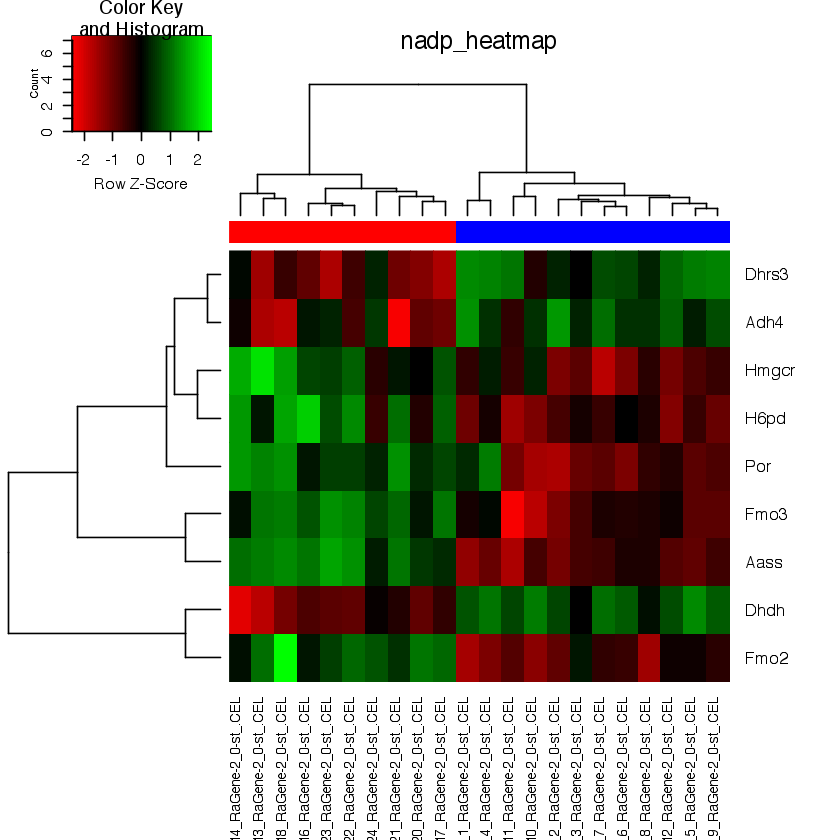

In [16]:
library(RColorBrewer)


col<-as.character(condition)

col[col=="ctrl"]<-"blue"
col[col=="GSK932121"]<-"red"
library(gplots)
library(AnnotationDbi, quietly=TRUE, warn.conflicts=F)
library(org.Rn.eg.db, quietly=TRUE, warn.conflicts=F)

ens <- AnnotationDbi::select(org.Rn.eg.db, keys = gsub("_at","",rownames(nadp)), keytype = "ENTREZID", 
                             columns = c("SYMBOL", "ENTREZID"))

dim(ens)
heatmap.2(nadp,ColSideColors=col,scale="row",denscol = F,labRow = ens$SYMBOL,margins = c(10, 7)
                ,trace='none',main="nadp_heatmap",col=redgreen(75),hclustfun=function(x)hclust(x,method="ward.D2"))

Now that we see that they can be differentiated we can diferentiate between the two groups we can make more questions. like, are they in the same compartment?

In [17]:
Go <- AnnotationDbi::select(org.Rn.eg.db, keys = gsub("_at","",rownames(nadp)), keytype = "ENTREZID", 
                             columns = c("ENTREZID","GO"))
Go<-(Go[Go$ONTOLOGY=="CC"&Go$GO!="GO:0005623"&Go$GO!="GO:0005575"&Go$GO!="GO:0005634",])

Go<-droplevels(Go)
head(Go)
tGOs<-sort((table(Go$GO)),decreasing = T)
tGOs<-tGOs[tGOs>3]
tGOs


'select()' returned 1:many mapping between keys and columns


,ENTREZID,GO,EVIDENCE,ONTOLOGY
5,246245,GO:0005789,IEA,CC
13,246245,GO:0016020,ISO,CC
14,246245,GO:0016020,ISS,CC
15,246245,GO:0016021,IEA,CC
29,25675,GO:0005778,IBA,CC
30,25675,GO:0005778,ISO,CC



GO:0043231 GO:0005739 GO:0016021 GO:0005789 GO:0016020 
         7          5          5          4          4 

Most of them are in more than one compartment so in order not to see all information we can make a barcode

In [18]:
tGOs[1:length(tGOs)]<-rep(0,length(tGOs))
tGOs
gene<-gsub("_at","",rownames(nadp))[1]
GObarcode<-function(gene, GoList){
    if(sum(Go$ENTREZID==gene)>=1){
        if(sum(names(GoList)%in% unique(Go[Go$ENTREZID==gene,"GO"]))>0){
            GoList[names(GoList)%in% unique(Go[Go$ENTREZID==gene,"GO"])]<-1
            return(paste(GoList,collapse=""))
        }
        return(paste(unique(Go[Go$ENTREZID==gene,"GO"]),collapse=","))
    }
    return("none")    
}

GOs<-sapply(gsub("_at","",rownames(nadp)),GObarcode,GoList=tGOs)



GO:0043231 GO:0005739 GO:0016021 GO:0005789 GO:0016020 
         0          0          0          0          0 

The order of the barcode is the same as the GO ids above

[1] 0

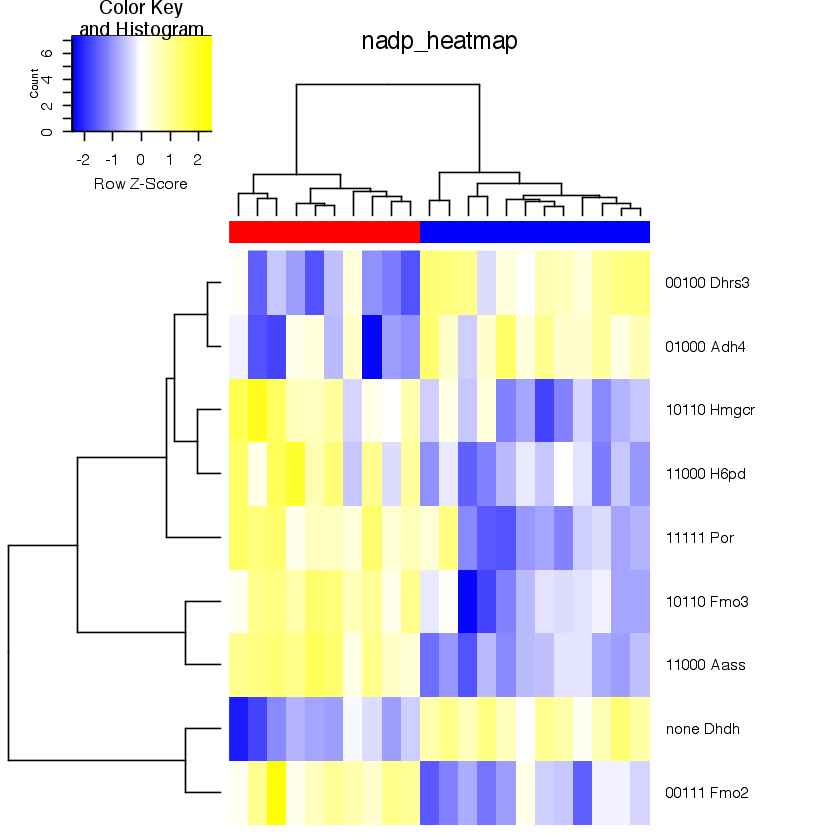

In [19]:
sum(Go$ENTREZID=="252931")
heatmap.2(nadp,ColSideColors=col,scale="row",denscol = F,labRow = paste(GOs, ens$SYMBOL),hclustfun=function(x)hclust(x,method="ward.D2")
                ,trace='none',main="nadp_heatmap",col=colorRampPalette(c("blue","white","yellow"))(75),margins = c(1, 12),cexRow=1.1)

We can also see how each of them correlate to each other

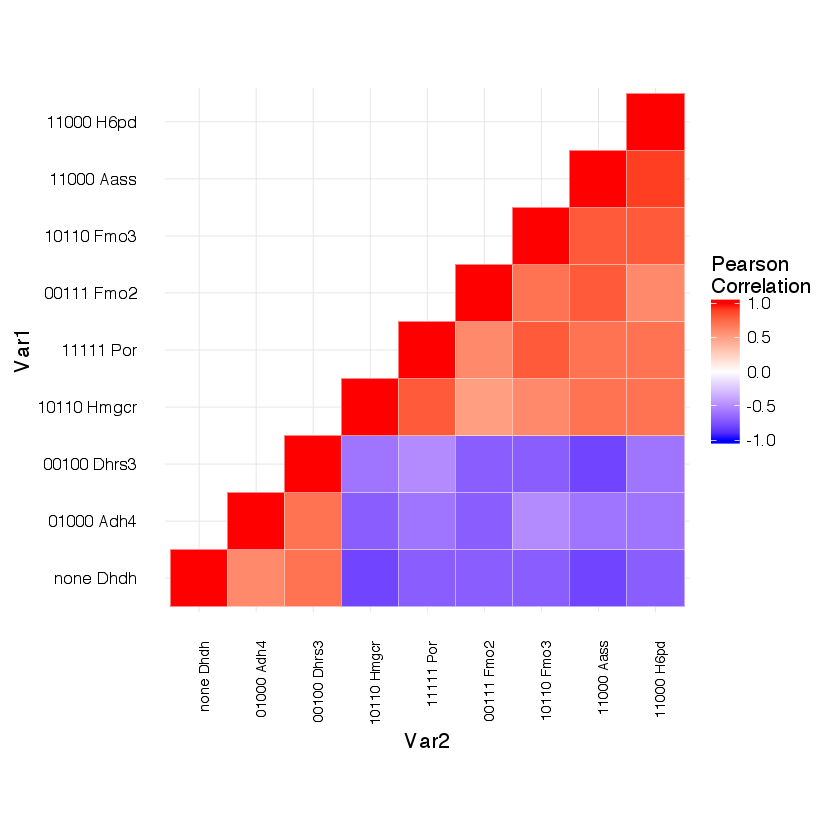

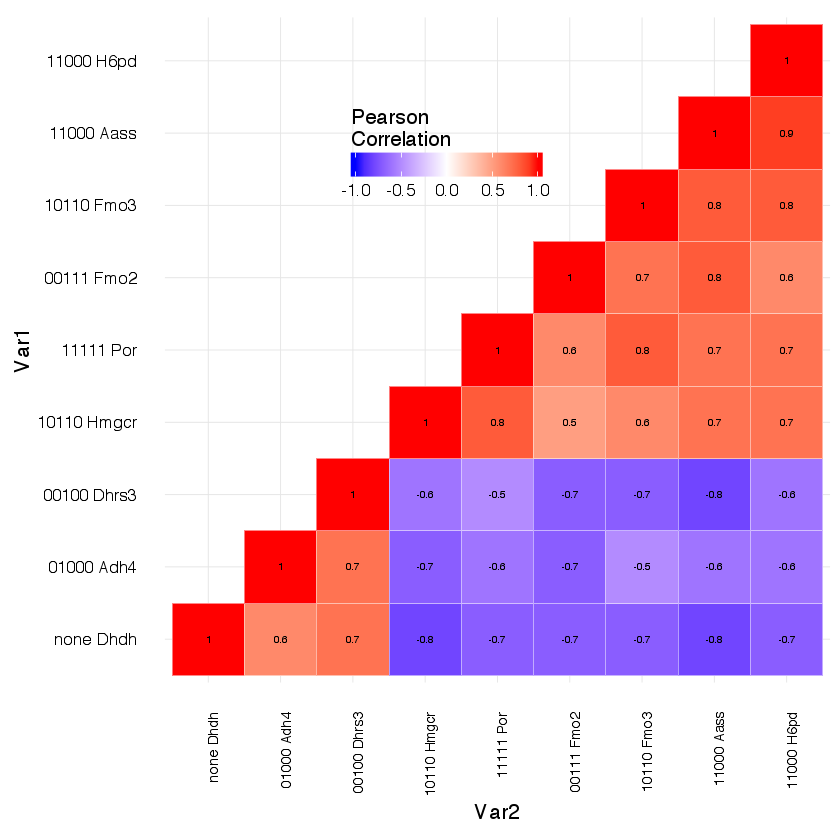

In [20]:
library(ggplot2)
cormat <- round(cor(t(nadp)),1)
rownames(cormat)<-paste(GOs,ens$SYMBOL)
colnames(cormat)<-paste(GOs,ens$SYMBOL)
library(reshape2)
melted_cormat <- melt(cormat)
get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)
  }
  # Get upper triangle of the correlation matrix
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }
reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd)
cormat <-cormat[hc$order, hc$order]
}
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)
# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 90, vjust = 1, 
    size = 8, hjust = 1))+
 coord_fixed()
# Print the heatmap
print(ggheatmap)
ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 2) +
theme(
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 8, barheight = 1,
                title.position = "top"))
melted_cormat<-melted_cormat[melted_cormat$value!=1,]

write.csv(melted_cormat[order(abs(melted_cormat$value),decreasing = T),],"cor_nadp.csv")